In [21]:
import random
import math

In [85]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [22]:
class Value:
    def __init__(self, data, _children = (), _op='', label='', grad = 0.0):
        self.data = data
        self._prev = set(_children) # used to store which Values were used to get this data
        self._op = _op # which operation was run on the children Values to get this data
        self._backward = lambda: None
        self.label = label # what should it be known as in the graph vis (just the var name usually)
        self.grad = grad # what is the gradient wrt to the final root node

    def __repr__(self):
        return f"Value (data = {self.data})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
        
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * (other ** -1)

    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise TypeError(f"Exponent must be an int or float, got {type(other).__name__}")

        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += out.grad * ( other * self.data ** (other - 1))
            
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    def tanhOld(self):
        x = self.data
        output = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(output, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - (out.data ** 2)) * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        e = (2 * self).exp()
        return (e - 1)/(e + 1)

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [30]:
class Neuron:
    # nin is the number of inputs being passed to the neuron
    # the number of x's in w1x1 + w2x2 + w3x3..
    def __init__(self, nin):
        # generate weights for the inputs, they can be randomised
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = random.uniform(-1,1)

    def __call__(self, x):
        # On n(x), you want to run the forward pass on the inputs 

        # first create the dot product of x's and w's => w1x1 + w2x2..
        dp = sum(xi * wi for xi, wi in zip(x, self.w))

        # add the bias, and run it through the activation function to squash
        out = (dp + self.b).tanh()
        
        return out
        
    

In [80]:
class Layer:
    # nin: number of inputs
    # nout: number of neurons (which is the same as number of neurons)
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]


    # x represents the inputs to the layer of neurons
    def __call__(self, x):
        out = []
        for n in self.neurons:
            out.append(n(x))
        return out[0] if len(out) == 1 else out
        
        
        

In [81]:
class MLP:
    # nin: (int) number of inputs
    # nouts: (list) Layers of neurons, each ele will be the number of neurons in that layer
    def __init__(self, nin, nouts):
        self.sz = [nin] + nouts
        self.layers = [Layer(self.sz[i], self.sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
        
        

In [82]:
m = MLP(3, [4, 4, 1])

In [83]:
x = [1.0, 2.0, 3.0]

In [86]:
o = m(x)

In [89]:
o.grad = 1
o.backward()

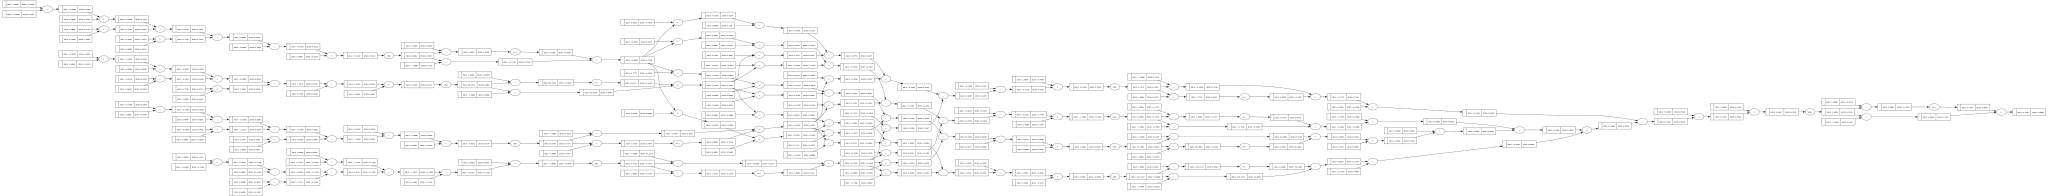

In [90]:
draw_dot(o)